# Indian Institute of Technolgy, Ropar
# B. Tech Project
## Prediction of costs for EV charging
### Team Members
* Yash Jain - 2019EEB1208
* Swapnil Saurav - 2019EEB1204
* Aishwarya Pal - 2019EEB1136

Under the Guidance of Dr. K. R. Sekhar and Nikhil.

Department of Electrical Engineering.

The overall Project is broken into subparts as follows:
1. Prediction of Irradiance from current weather data.
2. Prediction of Power from Irradiance and Temperature.
3. Estimation of cost of EV charging from grid and solar power availability.

We have used ML for the first two parts. 



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# for data handeling
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# for the model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score

# for API handeling
import requests
import json
from datetime import datetime
import pytz

# import tensorflow as tf
# from sklearn import tree
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import RandomForestRegressor

In [98]:
# loading the datasets
root = "/content/gdrive/MyDrive/BTP sem7 Group 2/"
combined_data = pd.read_csv(root+"combined_data.csv");
# matlab_data = pd.read_csv(root+"datasolar.csv")
matdata = pd.read_csv(root+"matdata.csv")

# max value of irradiance is considered as base and the whole data is normalized.
irr_base=combined_data['irradiance'].max()

for column in combined_data.columns:
    combined_data[column] = (combined_data[column] - combined_data[column].min()) / (combined_data[column].max() - combined_data[column].min())

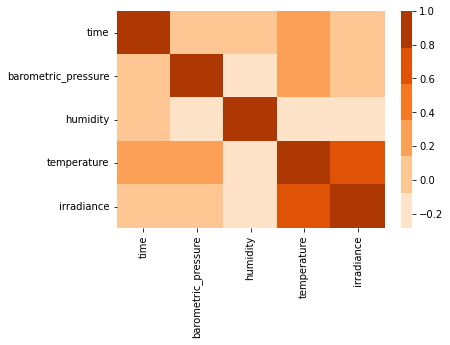

In [99]:
correlation = combined_data.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

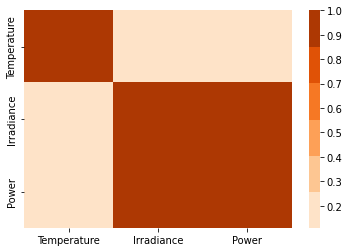

In [100]:
correlation = matdata.corr(method = 'pearson')
sns.heatmap(correlation, cmap=sns.color_palette("Oranges"))

In [101]:
# The below function will create the model, split the data, fit the model and checks the accuracies.
def model_maker(data,key):
    # creating the model.
    regressor = ExtraTreesRegressor(n_estimators = 100)

    # extracting X and Y from the data.
    df2 = data.iloc[:,:-1]
    X = df2.to_numpy()
    Y = data[key].to_numpy()

    # X_train and Y_train for training the model. X_test, Y_test for testing.
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=0.80, random_state=1)

    #fitting the model
    regressor.fit(X_train, Y_train)

    # Calcuting the accuracies
    accuracies = cross_val_score(estimator = regressor, X = X_train,y = Y_train, cv = 2, scoring = 'r2')
    accuracy = accuracies.mean()
    print('\n--------------------------------------------------\n')
    print('From Training Data:')
    print(f'r2 = {accuracy}\n')


    # predicting radiance and accuracy calculation
    y_pred = regressor.predict(X_test)
    explained_variance_score2 = explained_variance_score(Y_test, y_pred)
    mean_squared_error2 = mean_squared_error(Y_test, y_pred)
    r_squared = r2_score(Y_test, y_pred)

    
    print('From Testing Data:')
    print(f'explained variance = {explained_variance_score2}')
    print(f'mse = {mean_squared_error2}')
    print(f'r2 = {r_squared}')

    plt.plot(Y_test[:50])
    plt.plot(y_pred[:50])
    plt.show()
    print('\n--------------------------------------------------\n')
    return regressor


--------------------------------------------------

From Training Data:
r2 = 0.9111077847448963

From Testing Data:
explained variance = 0.9216547667201039
mse = 0.0030290223800841613
r2 = 0.9216544945995463


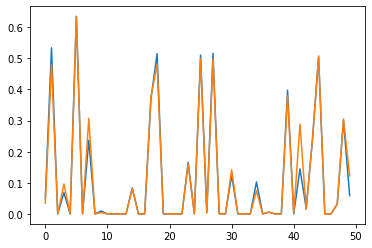


--------------------------------------------------


--------------------------------------------------

From Training Data:
r2 = 0.9686671971351426

From Testing Data:
explained variance = 0.9236805514462013
mse = 1003.7765044417886
r2 = 0.9016192045632073


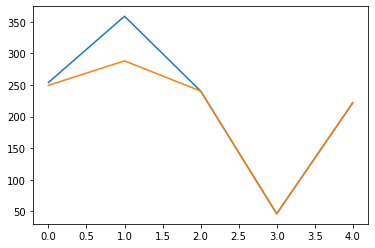


--------------------------------------------------



In [102]:
# creating the models for irradiance and voltage.
irradiance_model = model_maker(combined_data,'irradiance')
# voltage_model = model_maker(matlab_data,'Voltage')
mat_model = model_maker(matdata,'Power')

In [21]:
# The below function calculates the current time of the region in seconds after 00:00:00.
def currentTimeCalc(region='Asia/Calcutta'):
    tz = pytz.timezone(region)
    now = datetime.now(tz).strftime("%H:%M:%S")
    y = now.split(":")
    currTime = int(y[0])*3600 + int(y[1])*60 + int(y[2])
    return currTime
    
# The below function handles the API call.
def API_handler(lat=30.9688367,lon=76.526088):
    url = "https://api.openweathermap.org/data/2.5/weather?lat="+str(lat)+"&lon="+str(lon)+"&appid=2865c640108f7ea2169c32049fb48227"
    response = requests.get(url)

    if response.status_code == 200:
        print("Sucessfully fetched the data from the API.")
    else:
        print(f"Hello User!, there's a {response.status_code} error with your request. Can not fetch the data.")

    fetched_data = response.json()
    print(fetched_data)
    currTime = currentTimeCalc()
    currPress = fetched_data['main']['pressure'] / 33.86388666667           # hPa to inHg.
    currTemp = fetched_data['main']['temp'] - 273.15                        # K to deg C.
    currHumidity = fetched_data['main']['humidity']
    # print(currTime)
    return np.array([[currTime,currPress,currHumidity,currTemp]])

In [104]:
# Function to normalize the API data
def normalize_api_data(api_data, minPress, maxPress, minHum, maxHum, minTemp, maxTemp):
    tim = api_data[0][0]/(24*3600)
    pres = (api_data[0][1]-minPress)/(maxPress-minPress)
    hum = (api_data[0][2]-minHum)/(maxHum-minHum)
    temp = (api_data[0][3]-minTemp)/(maxTemp-minTemp)

    return [[tim, pres, hum, temp]]

# Function to verify the tuning via 24-hr plot
def plot_timewise(data):
    data2 = np.copy(data)
    res = []
    for i in range(0,86400,3600):
        data2[0][0]=i/(24*3600)
        irr = irradiance_model.predict(data2)[0]*irr_base
        res.append(irr)
    data2[0][0]=1
    plt.plot(range(0,24,1),res)

Sucessfully fetched the data from the API.
{'coord': {'lon': 76.5261, 'lat': 30.9688}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01d'}], 'base': 'stations', 'main': {'temp': 295.71, 'feels_like': 295.04, 'temp_min': 295.71, 'temp_max': 295.71, 'pressure': 1018, 'humidity': 39, 'sea_level': 1018, 'grnd_level': 986}, 'visibility': 10000, 'wind': {'speed': 2.16, 'deg': 323, 'gust': 2.67}, 'clouds': {'all': 0}, 'dt': 1668143331, 'sys': {'country': 'IN', 'sunrise': 1668129421, 'sunset': 1668167931}, 'timezone': 19800, 'id': 1257951, 'name': 'Ropar', 'cod': 200}
[[3.86530000e+04 3.00615228e+01 3.90000000e+01 2.25600000e+01]]


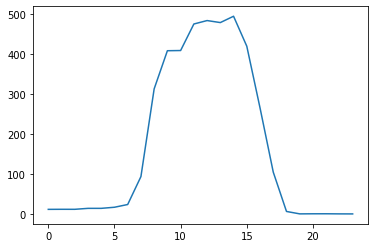

In [113]:
# Tuning of API data
api_data = API_handler()
print(api_data)
api_data = normalize_api_data(api_data, 20, 40, 30, 50, 15, 32)
plot_timewise(api_data)

In [114]:
# Predicting the Irradiance and Power at MPPT.

irr = irradiance_model.predict(api_data)[0]*irr_base
# vol = voltage_model.predict([[api_data[0][-1],irr]])[0]
pow = mat_model.predict([[api_data[0][-1],irr]])[0]

print(f"Irradiance = {irr} and OC Power = {pow}")

Irradiance = 462.233121896072 and OC Power = 109.80941800000006


In [115]:
print(combined_data)

           time  barometric_pressure  humidity  temperature  irradiance
0      0.999223             0.729730  0.757895     0.378378    0.000100
1      0.995800             0.729730  0.747368     0.378378    0.000087
2      0.992330             0.729730  0.747368     0.378378    0.000087
3      0.988815             0.729730  0.747368     0.378378    0.000087
4      0.985345             0.756757  0.747368     0.378378    0.000100
...         ...                  ...       ...          ...         ...
33128  0.013959             0.648649  0.989474     0.270270    0.000069
33129  0.010443             0.621622  0.989474     0.270270    0.000037
33130  0.006962             0.621622  0.989474     0.270270    0.000056
33131  0.003493             0.621622  0.978947     0.270270    0.000075
33132  0.000012             0.648649  0.978947     0.270270    0.000056

[33133 rows x 5 columns]
